# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11273
EM converged at iteration 35, llf=-11049, convergence criterion=9.6967e-07 < tolerance=1e-06
EM start iterations, llf=-11286
EM converged at iteration 35, llf=-11061, convergence criterion=9.742e-07 < tolerance=1e-06
EM start iterations, llf=-11337
EM converged at iteration 35, llf=-11109, convergence criterion=9.9144e-07 < tolerance=1e-06
EM start iterations, llf=-11343
EM converged at iteration 35, llf=-11116, convergence criterion=9.9127e-07 < tolerance=1e-06
EM start iterations, llf=-11416
EM converged at iteration 35, llf=-11183, convergence criterion=9.8295e-07 < tolerance=1e-06
EM start iterations, llf=-11425
EM converged at iteration 35, llf=-11190, convergence criterion=9.6463e-07 < tolerance=1e-06
EM start iterations, llf=-11480
EM converged at iteration 35, llf=-11246, convergence criterion=9.907e-07 < tolerance=1e-06
EM start iterations, llf=-11480
EM converged at iteration 35, llf=-11246, convergence criterion=9.907e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-12793
EM converged at iteration 37, llf=-12611, convergence criterion=9.6813e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM converged at iteration 33, llf=-12685, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-12863
EM converged at iteration 36, llf=-12689, convergence criterion=9.4504e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 36, llf=-12735, convergence criterion=9.899e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 36, llf=-12735, convergence criterion=9.899e-07 < tolerance=1e-06
EM start iterations, llf=-12926
EM converged at iteration 37, llf=-12748, convergence criterion=9.7629e-07 < tolerance=1e-06
EM start iterations, llf=-12977
EM converged at iteration 37, llf=-12800, convergence criterion=9.4867e-07 < tolerance=1e-06
EM start iterations, llf=-12982
EM converged at iteration 37, llf=-12804, convergence criterion=9.8385e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14435
EM converged at iteration 36, llf=-14243, convergence criterion=9.9063e-07 < tolerance=1e-06
EM start iterations, llf=-14435
EM converged at iteration 36, llf=-14243, convergence criterion=9.9063e-07 < tolerance=1e-06
EM start iterations, llf=-14444
EM converged at iteration 36, llf=-14252, convergence criterion=9.8967e-07 < tolerance=1e-06
EM start iterations, llf=-14495
EM converged at iteration 36, llf=-14303, convergence criterion=9.8e-07 < tolerance=1e-06
EM start iterations, llf=-14506
EM converged at iteration 36, llf=-14314, convergence criterion=9.7203e-07 < tolerance=1e-06
EM start iterations, llf=-14553
EM converged at iteration 36, llf=-14361, convergence criterion=9.4165e-07 < tolerance=1e-06
EM start iterations, llf=-14560
EM converged at iteration 35, llf=-14368, convergence criterion=9.9333e-07 < tolerance=1e-06
EM start iterations, llf=-14606
EM converged at iteration 35, llf=-14412, convergence criterion=9.7886e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16111
EM converged at iteration 31, llf=-15886, convergence criterion=9.8101e-07 < tolerance=1e-06
EM start iterations, llf=-16115
EM converged at iteration 31, llf=-15891, convergence criterion=9.8192e-07 < tolerance=1e-06
EM start iterations, llf=-16167
EM converged at iteration 31, llf=-15942, convergence criterion=9.6148e-07 < tolerance=1e-06
EM start iterations, llf=-16174
EM converged at iteration 31, llf=-15949, convergence criterion=9.6977e-07 < tolerance=1e-06
EM start iterations, llf=-16228
EM converged at iteration 31, llf=-16003, convergence criterion=9.6101e-07 < tolerance=1e-06
EM start iterations, llf=-16228
EM converged at iteration 31, llf=-16003, convergence criterion=9.6101e-07 < tolerance=1e-06
EM start iterations, llf=-16237
EM converged at iteration 31, llf=-16012, convergence criterion=9.4472e-07 < tolerance=1e-06
EM start iterations, llf=-16285
EM converged at iteration 31, llf=-16060, convergence criterion=9.0836e-07 < tolerance=1e-06


EM start iterations, llf=-17570
EM converged at iteration 26, llf=-17334, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-17625
EM converged at iteration 26, llf=-17387, convergence criterion=9.7814e-07 < tolerance=1e-06
EM start iterations, llf=-17625
EM converged at iteration 26, llf=-17387, convergence criterion=9.7814e-07 < tolerance=1e-06
EM start iterations, llf=-17630
EM converged at iteration 26, llf=-17393, convergence criterion=9.7875e-07 < tolerance=1e-06
EM start iterations, llf=-17682
EM converged at iteration 27, llf=-17442, convergence criterion=8.8318e-07 < tolerance=1e-06
EM start iterations, llf=-17688
EM converged at iteration 27, llf=-17450, convergence criterion=8.828e-07 < tolerance=1e-06
EM start iterations, llf=-17742
EM converged at iteration 27, llf=-17502, convergence criterion=8.9017e-07 < tolerance=1e-06
EM start iterations, llf=-17749
EM converged at iteration 27, llf=-17509, convergence criterion=8.9401e-07 < tolerance=1e-06
E

EM start iterations, llf=-11853
EM converged at iteration 44, llf=-11598, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-11836
EM converged at iteration 43, llf=-11578, convergence criterion=9.9461e-07 < tolerance=1e-06
EM start iterations, llf=-11947
EM converged at iteration 43, llf=-11691, convergence criterion=9.9887e-07 < tolerance=1e-06
EM start iterations, llf=-11966
EM converged at iteration 44, llf=-11716, convergence criterion=9.6269e-07 < tolerance=1e-06
EM start iterations, llf=-11962
EM converged at iteration 47, llf=-11736, convergence criterion=9.8242e-07 < tolerance=1e-06
EM start iterations, llf=-11961
EM converged at iteration 47, llf=-11733, convergence criterion=9.6059e-07 < tolerance=1e-06
EM start iterations, llf=-11932
EM converged at iteration 44, llf=-11712, convergence criterion=9.6033e-07 < tolerance=1e-06
EM start iterations, llf=-11932
EM converged at iteration 44, llf=-11712, convergence criterion=9.6033e-07 < tolerance=1e-06


EM start iterations, llf=-13300
EM converged at iteration 53, llf=-13109, convergence criterion=9.9375e-07 < tolerance=1e-06
EM start iterations, llf=-13327
EM converged at iteration 52, llf=-13129, convergence criterion=9.8626e-07 < tolerance=1e-06
EM start iterations, llf=-13333
EM converged at iteration 54, llf=-13141, convergence criterion=9.7332e-07 < tolerance=1e-06
EM start iterations, llf=-13372
EM converged at iteration 57, llf=-13188, convergence criterion=9.8042e-07 < tolerance=1e-06
EM start iterations, llf=-13372
EM converged at iteration 57, llf=-13188, convergence criterion=9.8042e-07 < tolerance=1e-06
EM start iterations, llf=-13383
EM converged at iteration 57, llf=-13199, convergence criterion=9.8315e-07 < tolerance=1e-06
EM start iterations, llf=-13429
EM converged at iteration 56, llf=-13244, convergence criterion=9.945e-07 < tolerance=1e-06
EM start iterations, llf=-13437
EM converged at iteration 55, llf=-13251, convergence criterion=9.9974e-07 < tolerance=1e-06
E

EM start iterations, llf=-14973
EM converged at iteration 48, llf=-14764, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-14973
EM converged at iteration 48, llf=-14764, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-14981
EM converged at iteration 48, llf=-14772, convergence criterion=9.7391e-07 < tolerance=1e-06
EM start iterations, llf=-15032
EM converged at iteration 48, llf=-14821, convergence criterion=9.7368e-07 < tolerance=1e-06
EM start iterations, llf=-15035
EM converged at iteration 48, llf=-14823, convergence criterion=9.7959e-07 < tolerance=1e-06
EM start iterations, llf=-15090
EM converged at iteration 47, llf=-14877, convergence criterion=9.8134e-07 < tolerance=1e-06
EM start iterations, llf=-15095
EM converged at iteration 47, llf=-14881, convergence criterion=9.78e-07 < tolerance=1e-06
EM start iterations, llf=-15138
EM converged at iteration 47, llf=-14925, convergence criterion=9.8292e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16653
EM converged at iteration 38, llf=-16429, convergence criterion=9.8654e-07 < tolerance=1e-06
EM start iterations, llf=-16658
EM converged at iteration 38, llf=-16434, convergence criterion=9.8585e-07 < tolerance=1e-06
EM start iterations, llf=-16710
EM converged at iteration 38, llf=-16485, convergence criterion=9.7968e-07 < tolerance=1e-06
EM start iterations, llf=-16718
EM converged at iteration 38, llf=-16492, convergence criterion=9.7845e-07 < tolerance=1e-06
EM start iterations, llf=-16762
EM converged at iteration 38, llf=-16536, convergence criterion=9.7197e-07 < tolerance=1e-06
EM start iterations, llf=-16762
EM converged at iteration 38, llf=-16536, convergence criterion=9.7197e-07 < tolerance=1e-06
EM start iterations, llf=-16782
EM converged at iteration 38, llf=-16555, convergence criterion=9.7814e-07 < tolerance=1e-06
EM start iterations, llf=-16832
EM converged at iteration 37, llf=-16606, convergence criterion=9.7643e-07 < tolerance=1e-06


EM start iterations, llf=-18095
EM converged at iteration 37, llf=-17842, convergence criterion=9.7814e-07 < tolerance=1e-06
EM start iterations, llf=-18143
EM converged at iteration 37, llf=-17890, convergence criterion=9.5477e-07 < tolerance=1e-06
EM start iterations, llf=-18143
EM converged at iteration 37, llf=-17890, convergence criterion=9.5477e-07 < tolerance=1e-06
EM start iterations, llf=-18150
EM converged at iteration 37, llf=-17899, convergence criterion=9.5289e-07 < tolerance=1e-06
EM start iterations, llf=-18208
EM converged at iteration 37, llf=-17956, convergence criterion=9.5068e-07 < tolerance=1e-06
EM start iterations, llf=-18216
EM converged at iteration 36, llf=-17964, convergence criterion=9.9958e-07 < tolerance=1e-06
EM start iterations, llf=-18267
EM converged at iteration 36, llf=-18014, convergence criterion=9.9754e-07 < tolerance=1e-06
EM start iterations, llf=-18276
EM converged at iteration 36, llf=-18022, convergence criterion=9.9627e-07 < tolerance=1e-06


EM start iterations, llf=-12123
EM converged at iteration 44, llf=-11919, convergence criterion=9.4973e-07 < tolerance=1e-06
EM start iterations, llf=-12129
EM converged at iteration 44, llf=-11925, convergence criterion=9.4717e-07 < tolerance=1e-06
EM start iterations, llf=-12173
EM converged at iteration 43, llf=-11966, convergence criterion=9.7595e-07 < tolerance=1e-06
EM start iterations, llf=-12180
EM converged at iteration 43, llf=-11973, convergence criterion=9.8047e-07 < tolerance=1e-06
EM start iterations, llf=-12231
EM converged at iteration 50, llf=-12019, convergence criterion=9.6665e-07 < tolerance=1e-06
EM start iterations, llf=-12241
EM converged at iteration 50, llf=-12029, convergence criterion=9.5921e-07 < tolerance=1e-06
EM start iterations, llf=-12299
EM converged at iteration 51, llf=-12093, convergence criterion=9.8969e-07 < tolerance=1e-06
EM start iterations, llf=-12299
EM converged at iteration 51, llf=-12093, convergence criterion=9.8969e-07 < tolerance=1e-06


EM start iterations, llf=-13782
EM converged at iteration 54, llf=-13592, convergence criterion=9.8557e-07 < tolerance=1e-06
EM start iterations, llf=-13835
EM converged at iteration 55, llf=-13648, convergence criterion=9.6415e-07 < tolerance=1e-06
EM start iterations, llf=-13843
EM converged at iteration 54, llf=-13653, convergence criterion=9.8344e-07 < tolerance=1e-06
EM start iterations, llf=-13894
EM converged at iteration 55, llf=-13706, convergence criterion=9.7477e-07 < tolerance=1e-06
EM start iterations, llf=-13894
EM converged at iteration 55, llf=-13706, convergence criterion=9.7477e-07 < tolerance=1e-06
EM start iterations, llf=-13902
EM converged at iteration 54, llf=-13713, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-13956
EM converged at iteration 54, llf=-13765, convergence criterion=9.8717e-07 < tolerance=1e-06
EM start iterations, llf=-13965
EM converged at iteration 53, llf=-13772, convergence criterion=9.9632e-07 < tolerance=1e-06


EM start iterations, llf=-15500
EM converged at iteration 51, llf=-15285, convergence criterion=9.6161e-07 < tolerance=1e-06
EM start iterations, llf=-15500
EM converged at iteration 51, llf=-15285, convergence criterion=9.6161e-07 < tolerance=1e-06
EM start iterations, llf=-15509
EM converged at iteration 51, llf=-15294, convergence criterion=9.6263e-07 < tolerance=1e-06
EM start iterations, llf=-15560
EM converged at iteration 50, llf=-15343, convergence criterion=9.9651e-07 < tolerance=1e-06
EM start iterations, llf=-15569
EM converged at iteration 50, llf=-15352, convergence criterion=9.9417e-07 < tolerance=1e-06
EM start iterations, llf=-15617
EM converged at iteration 50, llf=-15400, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-15624
EM converged at iteration 50, llf=-15407, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-15675
EM converged at iteration 50, llf=-15456, convergence criterion=9.8719e-07 < tolerance=1e-06


EM start iterations, llf=-17169
EM converged at iteration 41, llf=-16936, convergence criterion=9.9749e-07 < tolerance=1e-06
EM start iterations, llf=-17175
EM converged at iteration 41, llf=-16944, convergence criterion=9.93e-07 < tolerance=1e-06
EM start iterations, llf=-17224
EM converged at iteration 41, llf=-16991, convergence criterion=9.804e-07 < tolerance=1e-06
EM start iterations, llf=-17231
EM converged at iteration 41, llf=-16998, convergence criterion=9.8107e-07 < tolerance=1e-06
EM start iterations, llf=-17285
EM converged at iteration 41, llf=-17052, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-17285
EM converged at iteration 41, llf=-17052, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-17289
EM converged at iteration 41, llf=-17054, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-17342
EM converged at iteration 41, llf=-17106, convergence criterion=9.8092e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18334
EM converged at iteration 41, llf=-18075, convergence criterion=9.9444e-07 < tolerance=1e-06
EM start iterations, llf=-18386
EM converged at iteration 41, llf=-18127, convergence criterion=9.92e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:41:59.940858.
EM start iterations, llf=-10795
EM converged at iteration 39, llf=-10666, convergence criterion=9.9803e-07 < tolerance=1e-06
EM start iterations, llf=-10808
EM converged at iteration 39, llf=-10678, convergence criterion=9.688e-07 < tolerance=1e-06
EM start iterations, llf=-10857
EM converged at iteration 38, llf=-10728, convergence criterion=9.7007e-07 < tolerance=1e-06
EM start iterations, llf=-10865
EM converged at iteration 38, llf=-10736, convergence criterion=9.7078e-07 < tolerance=1e-06
EM start iterations, llf=-10931
EM converged at iteration 35, llf=-10802, convergence criterion=9.8248e-07 < tolerance=1e-06
EM start iterations, llf=-10941
EM converged at it

EM start iterations, llf=-12076
EM converged at iteration 26, llf=-11935, convergence criterion=9.5132e-07 < tolerance=1e-06
EM start iterations, llf=-12089
EM converged at iteration 26, llf=-11948, convergence criterion=9.643e-07 < tolerance=1e-06
EM start iterations, llf=-12122
EM converged at iteration 26, llf=-11980, convergence criterion=9.7322e-07 < tolerance=1e-06
EM start iterations, llf=-12128
EM converged at iteration 26, llf=-11984, convergence criterion=9.9278e-07 < tolerance=1e-06
EM start iterations, llf=-12190
EM converged at iteration 26, llf=-12039, convergence criterion=9.9457e-07 < tolerance=1e-06
EM start iterations, llf=-12195
EM converged at iteration 26, llf=-12046, convergence criterion=9.4351e-07 < tolerance=1e-06
EM start iterations, llf=-12235
EM converged at iteration 25, llf=-12087, convergence criterion=9.4813e-07 < tolerance=1e-06
EM start iterations, llf=-12235
EM converged at iteration 25, llf=-12087, convergence criterion=9.4813e-07 < tolerance=1e-06
E

EM start iterations, llf=-13600
EM converged at iteration 21, llf=-13448, convergence criterion=9.5135e-07 < tolerance=1e-06
EM start iterations, llf=-13642
EM converged at iteration 22, llf=-13492, convergence criterion=9.2106e-07 < tolerance=1e-06
EM start iterations, llf=-13650
EM converged at iteration 22, llf=-13499, convergence criterion=9.2156e-07 < tolerance=1e-06
EM start iterations, llf=-13702
EM converged at iteration 21, llf=-13549, convergence criterion=9.8389e-07 < tolerance=1e-06
EM start iterations, llf=-13702
EM converged at iteration 21, llf=-13549, convergence criterion=9.8389e-07 < tolerance=1e-06
EM start iterations, llf=-13709
EM converged at iteration 21, llf=-13558, convergence criterion=9.8308e-07 < tolerance=1e-06
EM start iterations, llf=-13758
EM converged at iteration 21, llf=-13605, convergence criterion=9.6863e-07 < tolerance=1e-06
EM start iterations, llf=-13765
EM converged at iteration 21, llf=-13612, convergence criterion=9.6038e-07 < tolerance=1e-06


EM start iterations, llf=-15253
EM converged at iteration 19, llf=-15091, convergence criterion=9.7059e-07 < tolerance=1e-06
EM start iterations, llf=-15253
EM converged at iteration 19, llf=-15091, convergence criterion=9.7059e-07 < tolerance=1e-06
EM start iterations, llf=-15267
EM converged at iteration 19, llf=-15104, convergence criterion=9.6802e-07 < tolerance=1e-06
EM start iterations, llf=-15320
EM converged at iteration 19, llf=-15159, convergence criterion=9.9574e-07 < tolerance=1e-06
EM start iterations, llf=-15322
EM converged at iteration 20, llf=-15161, convergence criterion=9.1923e-07 < tolerance=1e-06
EM start iterations, llf=-15373
EM converged at iteration 19, llf=-15212, convergence criterion=9.9686e-07 < tolerance=1e-06
EM start iterations, llf=-15380
EM converged at iteration 20, llf=-15219, convergence criterion=9.1482e-07 < tolerance=1e-06
EM start iterations, llf=-15430
EM converged at iteration 20, llf=-15269, convergence criterion=9.3436e-07 < tolerance=1e-06


EM start iterations, llf=-16640
EM converged at iteration 19, llf=-16476, convergence criterion=9.4613e-07 < tolerance=1e-06
EM start iterations, llf=-16654
EM converged at iteration 19, llf=-16489, convergence criterion=9.3933e-07 < tolerance=1e-06
EM start iterations, llf=-16707
EM converged at iteration 19, llf=-16540, convergence criterion=9.2944e-07 < tolerance=1e-06
EM start iterations, llf=-16713
EM converged at iteration 19, llf=-16546, convergence criterion=9.2786e-07 < tolerance=1e-06
EM start iterations, llf=-16765
EM converged at iteration 18, llf=-16598, convergence criterion=9.9677e-07 < tolerance=1e-06
EM start iterations, llf=-16765
EM converged at iteration 18, llf=-16598, convergence criterion=9.9677e-07 < tolerance=1e-06
EM start iterations, llf=-16770
EM converged at iteration 19, llf=-16603, convergence criterion=9.0517e-07 < tolerance=1e-06
EM start iterations, llf=-16818
EM converged at iteration 18, llf=-16651, convergence criterion=9.934e-07 < tolerance=1e-06
E

EM start iterations, llf=-11264
EM converged at iteration 53, llf=-11125, convergence criterion=9.971e-07 < tolerance=1e-06
EM start iterations, llf=-11267
EM converged at iteration 53, llf=-11127, convergence criterion=9.8906e-07 < tolerance=1e-06
EM start iterations, llf=-11339
EM converged at iteration 48, llf=-11199, convergence criterion=9.7181e-07 < tolerance=1e-06
EM start iterations, llf=-11339
EM converged at iteration 48, llf=-11199, convergence criterion=9.7181e-07 < tolerance=1e-06
EM start iterations, llf=-11351
EM converged at iteration 50, llf=-11213, convergence criterion=9.7803e-07 < tolerance=1e-06
EM start iterations, llf=-11475
EM converged at iteration 51, llf=-11332, convergence criterion=9.7143e-07 < tolerance=1e-06
EM start iterations, llf=-11461
EM converged at iteration 51, llf=-11318, convergence criterion=9.6943e-07 < tolerance=1e-06
EM start iterations, llf=-11413
EM converged at iteration 49, llf=-11264, convergence criterion=9.7955e-07 < tolerance=1e-06
E

EM start iterations, llf=-12550
EM converged at iteration 33, llf=-12395, convergence criterion=9.7303e-07 < tolerance=1e-06
EM start iterations, llf=-12558
EM converged at iteration 32, llf=-12406, convergence criterion=9.9999e-07 < tolerance=1e-06
EM start iterations, llf=-12594
EM converged at iteration 33, llf=-12441, convergence criterion=9.8159e-07 < tolerance=1e-06
EM start iterations, llf=-12603
EM converged at iteration 34, llf=-12450, convergence criterion=9.6977e-07 < tolerance=1e-06
EM start iterations, llf=-12636
EM converged at iteration 33, llf=-12482, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-12628
EM converged at iteration 32, llf=-12478, convergence criterion=9.9568e-07 < tolerance=1e-06
EM start iterations, llf=-12663
EM converged at iteration 32, llf=-12512, convergence criterion=9.8172e-07 < tolerance=1e-06
EM start iterations, llf=-12663
EM converged at iteration 32, llf=-12512, convergence criterion=9.8172e-07 < tolerance=1e-06


EM start iterations, llf=-14106
EM converged at iteration 26, llf=-13950, convergence criterion=9.9193e-07 < tolerance=1e-06
EM start iterations, llf=-14161
EM converged at iteration 26, llf=-14004, convergence criterion=9.9176e-07 < tolerance=1e-06
EM start iterations, llf=-14167
EM converged at iteration 26, llf=-14010, convergence criterion=9.9194e-07 < tolerance=1e-06
EM start iterations, llf=-14210
EM converged at iteration 26, llf=-14056, convergence criterion=9.515e-07 < tolerance=1e-06
EM start iterations, llf=-14210
EM converged at iteration 26, llf=-14056, convergence criterion=9.515e-07 < tolerance=1e-06
EM start iterations, llf=-14223
EM converged at iteration 26, llf=-14067, convergence criterion=9.4321e-07 < tolerance=1e-06
EM start iterations, llf=-14276
EM converged at iteration 26, llf=-14118, convergence criterion=9.5886e-07 < tolerance=1e-06
EM start iterations, llf=-14275
EM converged at iteration 26, llf=-14119, convergence criterion=9.6081e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15765
EM converged at iteration 22, llf=-15599, convergence criterion=9.7341e-07 < tolerance=1e-06
EM start iterations, llf=-15765
EM converged at iteration 22, llf=-15599, convergence criterion=9.7341e-07 < tolerance=1e-06
EM start iterations, llf=-15774
EM converged at iteration 22, llf=-15606, convergence criterion=9.7397e-07 < tolerance=1e-06
EM start iterations, llf=-15820
EM converged at iteration 22, llf=-15651, convergence criterion=9.6508e-07 < tolerance=1e-06
EM start iterations, llf=-15824
EM converged at iteration 22, llf=-15656, convergence criterion=9.6216e-07 < tolerance=1e-06
EM start iterations, llf=-15875
EM converged at iteration 22, llf=-15707, convergence criterion=9.4983e-07 < tolerance=1e-06
EM start iterations, llf=-15884
EM converged at iteration 22, llf=-15717, convergence criterion=9.5954e-07 < tolerance=1e-06
EM start iterations, llf=-15926
EM converged at iteration 22, llf=-15758, convergence criterion=9.7027e-07 < tolerance=1e-06


EM start iterations, llf=-17151
EM converged at iteration 23, llf=-16979, convergence criterion=9.7899e-07 < tolerance=1e-06
EM start iterations, llf=-17158
EM converged at iteration 23, llf=-16986, convergence criterion=9.7425e-07 < tolerance=1e-06
EM start iterations, llf=-17202
EM converged at iteration 23, llf=-17031, convergence criterion=9.5199e-07 < tolerance=1e-06
EM start iterations, llf=-17210
EM converged at iteration 23, llf=-17037, convergence criterion=9.4702e-07 < tolerance=1e-06
EM start iterations, llf=-17254
EM converged at iteration 23, llf=-17081, convergence criterion=9.445e-07 < tolerance=1e-06
EM start iterations, llf=-17254
EM converged at iteration 23, llf=-17081, convergence criterion=9.445e-07 < tolerance=1e-06
EM start iterations, llf=-17259
EM converged at iteration 23, llf=-17086, convergence criterion=9.4787e-07 < tolerance=1e-06
EM start iterations, llf=-17315
EM converged at iteration 23, llf=-17141, convergence criterion=9.4676e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11430
EM converged at iteration 71, llf=-11285, convergence criterion=9.95e-07 < tolerance=1e-06
EM start iterations, llf=-11463
EM converged at iteration 57, llf=-11318, convergence criterion=9.9559e-07 < tolerance=1e-06
EM start iterations, llf=-11479
EM converged at iteration 56, llf=-11329, convergence criterion=9.8386e-07 < tolerance=1e-06
EM start iterations, llf=-11535
EM converged at iteration 57, llf=-11384, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-11535
EM converged at iteration 57, llf=-11384, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-11537
EM converged at iteration 60, llf=-11388, convergence criterion=9.8154e-07 < tolerance=1e-06
EM start iterations, llf=-11571
EM converged at iteration 61, llf=-11425, convergence criterion=9.8999e-07 < tolerance=1e-06
EM start iterations, llf=-11581
EM converged at iteration 62, llf=-11434, convergence criterion=9.7543e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12995
EM converged at iteration 52, llf=-12840, convergence criterion=9.7789e-07 < tolerance=1e-06
EM start iterations, llf=-12995
EM converged at iteration 52, llf=-12840, convergence criterion=9.7789e-07 < tolerance=1e-06
EM start iterations, llf=-13001
EM converged at iteration 52, llf=-12846, convergence criterion=9.788e-07 < tolerance=1e-06
EM start iterations, llf=-13058
EM converged at iteration 50, llf=-12904, convergence criterion=9.938e-07 < tolerance=1e-06
EM start iterations, llf=-13064
EM converged at iteration 50, llf=-12910, convergence criterion=9.7375e-07 < tolerance=1e-06
EM start iterations, llf=-13113
EM converged at iteration 50, llf=-12958, convergence criterion=9.7017e-07 < tolerance=1e-06
EM start iterations, llf=-13121
EM converged at iteration 49, llf=-12968, convergence criterion=9.6943e-07 < tolerance=1e-06
EM start iterations, llf=-13172
EM converged at iteration 47, llf=-13016, convergence criterion=9.9154e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14611
EM converged at iteration 43, llf=-14450, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-14614
EM converged at iteration 43, llf=-14454, convergence criterion=9.8416e-07 < tolerance=1e-06
EM start iterations, llf=-14668
EM converged at iteration 43, llf=-14506, convergence criterion=9.8418e-07 < tolerance=1e-06
EM start iterations, llf=-14673
EM converged at iteration 43, llf=-14511, convergence criterion=9.8659e-07 < tolerance=1e-06
EM start iterations, llf=-14727
EM converged at iteration 44, llf=-14565, convergence criterion=9.7742e-07 < tolerance=1e-06
EM start iterations, llf=-14727
EM converged at iteration 44, llf=-14565, convergence criterion=9.7742e-07 < tolerance=1e-06
EM start iterations, llf=-14737
EM converged at iteration 44, llf=-14575, convergence criterion=9.6978e-07 < tolerance=1e-06
EM start iterations, llf=-14786
EM converged at iteration 44, llf=-14623, convergence criterion=9.6475e-07 < tolerance=1e-06


EM start iterations, llf=-16226
EM converged at iteration 46, llf=-16055, convergence criterion=9.7685e-07 < tolerance=1e-06
EM start iterations, llf=-16273
EM converged at iteration 46, llf=-16103, convergence criterion=9.8529e-07 < tolerance=1e-06
EM start iterations, llf=-16273
EM converged at iteration 46, llf=-16103, convergence criterion=9.8529e-07 < tolerance=1e-06
EM start iterations, llf=-16280
EM converged at iteration 46, llf=-16110, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-16327
EM converged at iteration 45, llf=-16156, convergence criterion=9.8677e-07 < tolerance=1e-06
EM start iterations, llf=-16334
EM converged at iteration 45, llf=-16162, convergence criterion=9.824e-07 < tolerance=1e-06
EM start iterations, llf=-16381
EM converged at iteration 45, llf=-16209, convergence criterion=9.9858e-07 < tolerance=1e-06
EM start iterations, llf=-16389
EM converged at iteration 46, llf=-16217, convergence criterion=9.7385e-07 < tolerance=1e-06
E

EM start iterations, llf=-17311
EM converged at iteration 43, llf=-17139, convergence criterion=9.6991e-07 < tolerance=1e-06
EM start iterations, llf=-17361
EM converged at iteration 41, llf=-17191, convergence criterion=9.8625e-07 < tolerance=1e-06
EM start iterations, llf=-17372
EM converged at iteration 41, llf=-17202, convergence criterion=9.8155e-07 < tolerance=1e-06
EM start iterations, llf=-17424
EM converged at iteration 42, llf=-17253, convergence criterion=9.6961e-07 < tolerance=1e-06
EM start iterations, llf=-17428
EM converged at iteration 42, llf=-17257, convergence criterion=9.6969e-07 < tolerance=1e-06
EM start iterations, llf=-17478
EM converged at iteration 41, llf=-17307, convergence criterion=9.9441e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:05:16.158645.
Overall time taken for running all models: 8:53:57.437374.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


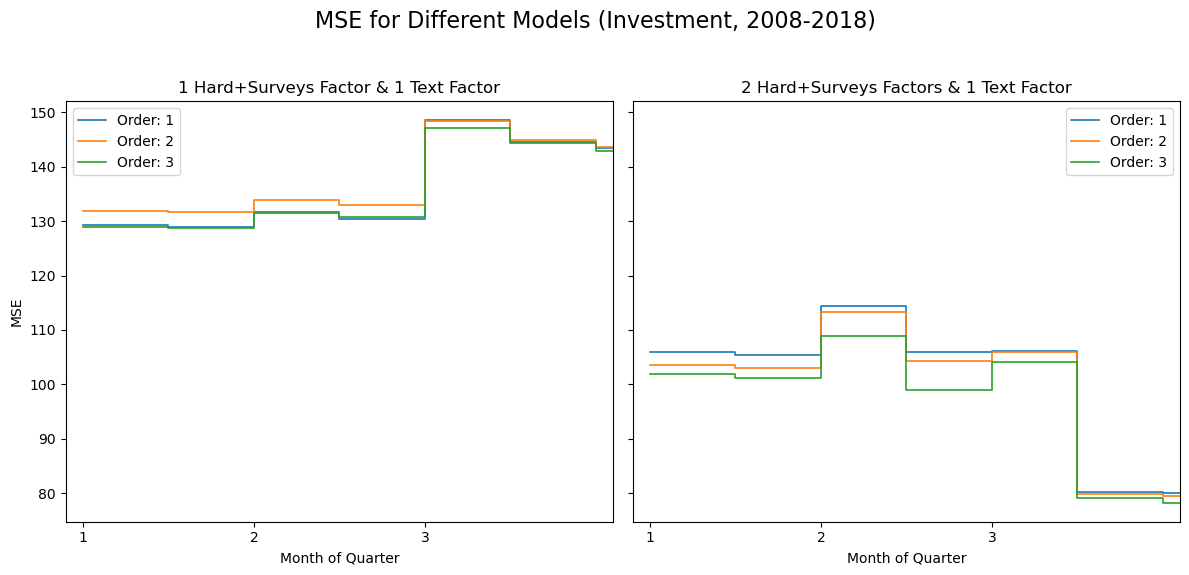

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


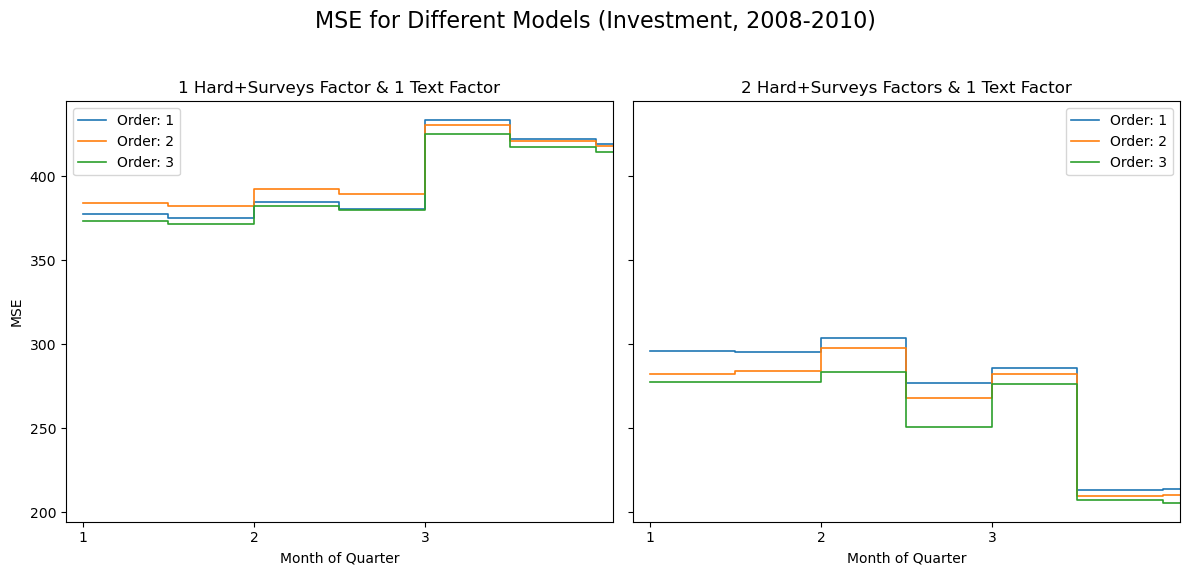

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


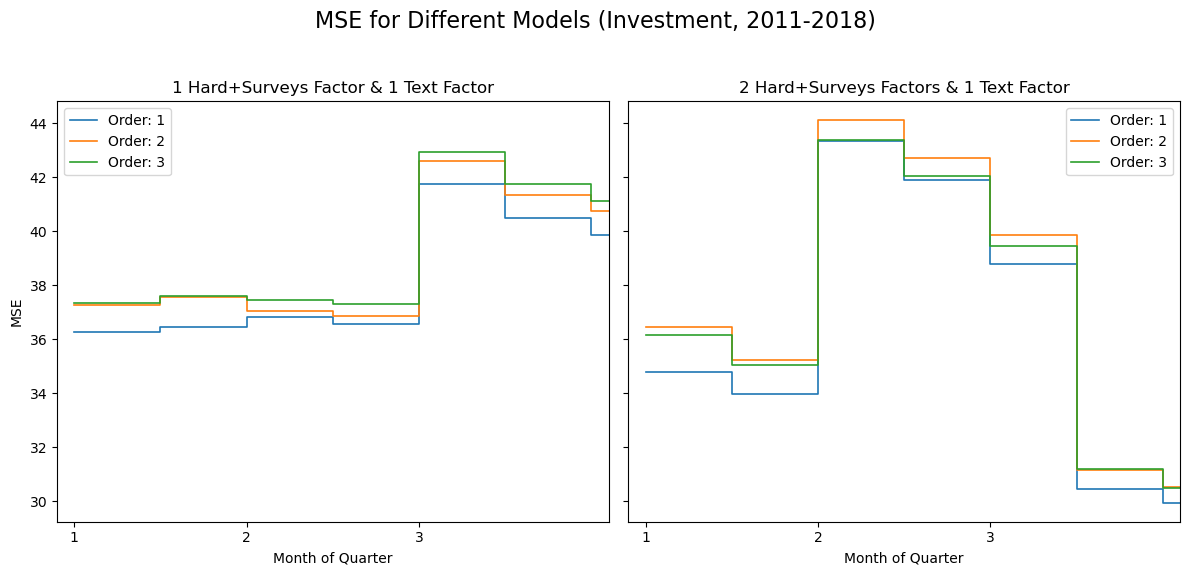

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


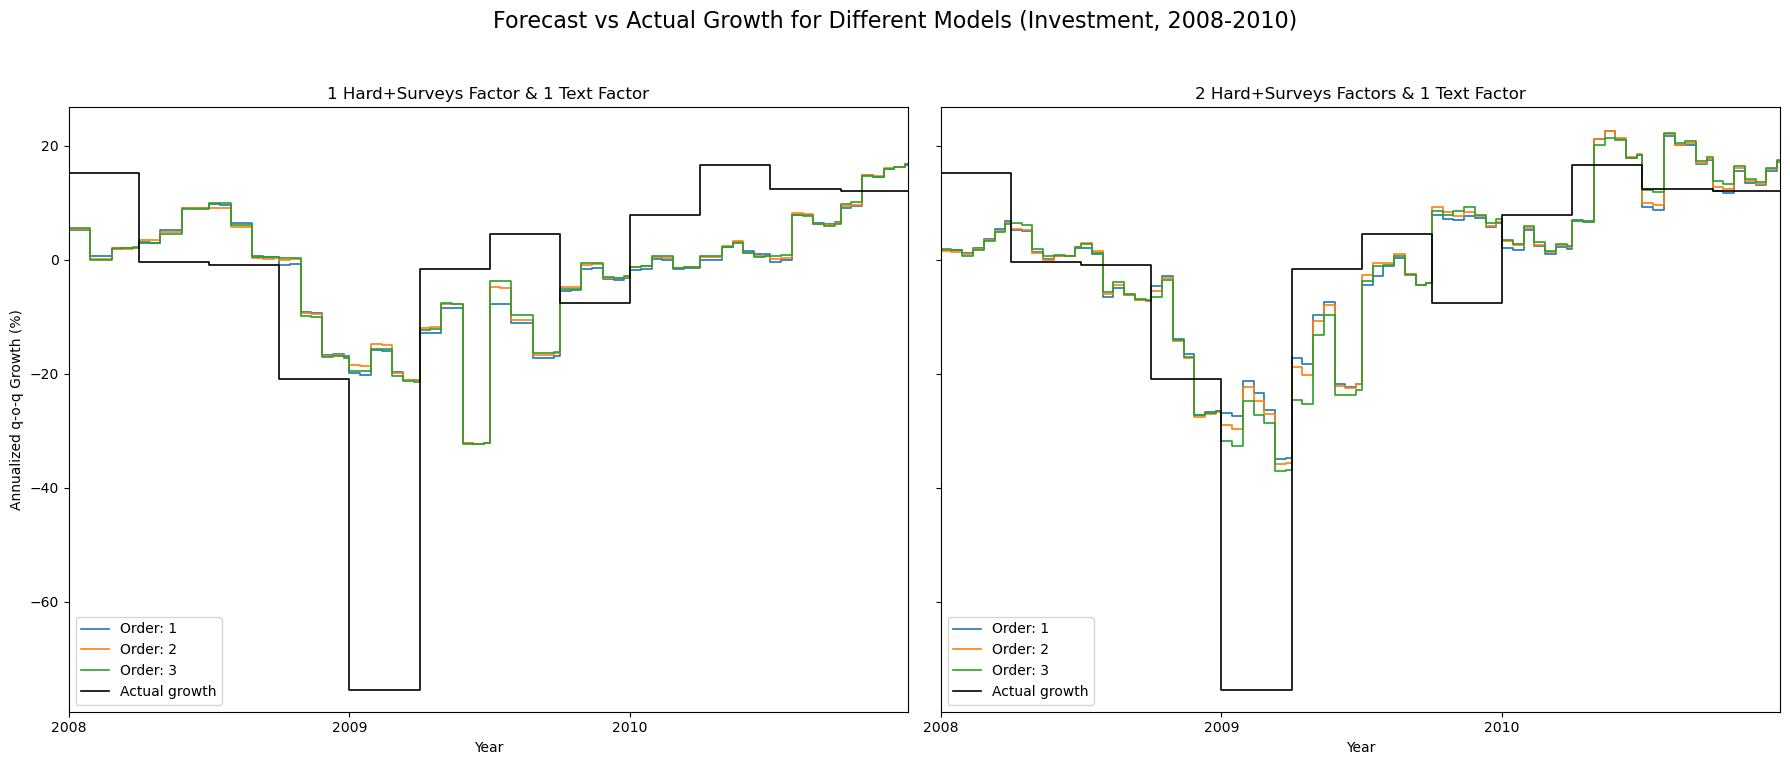

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


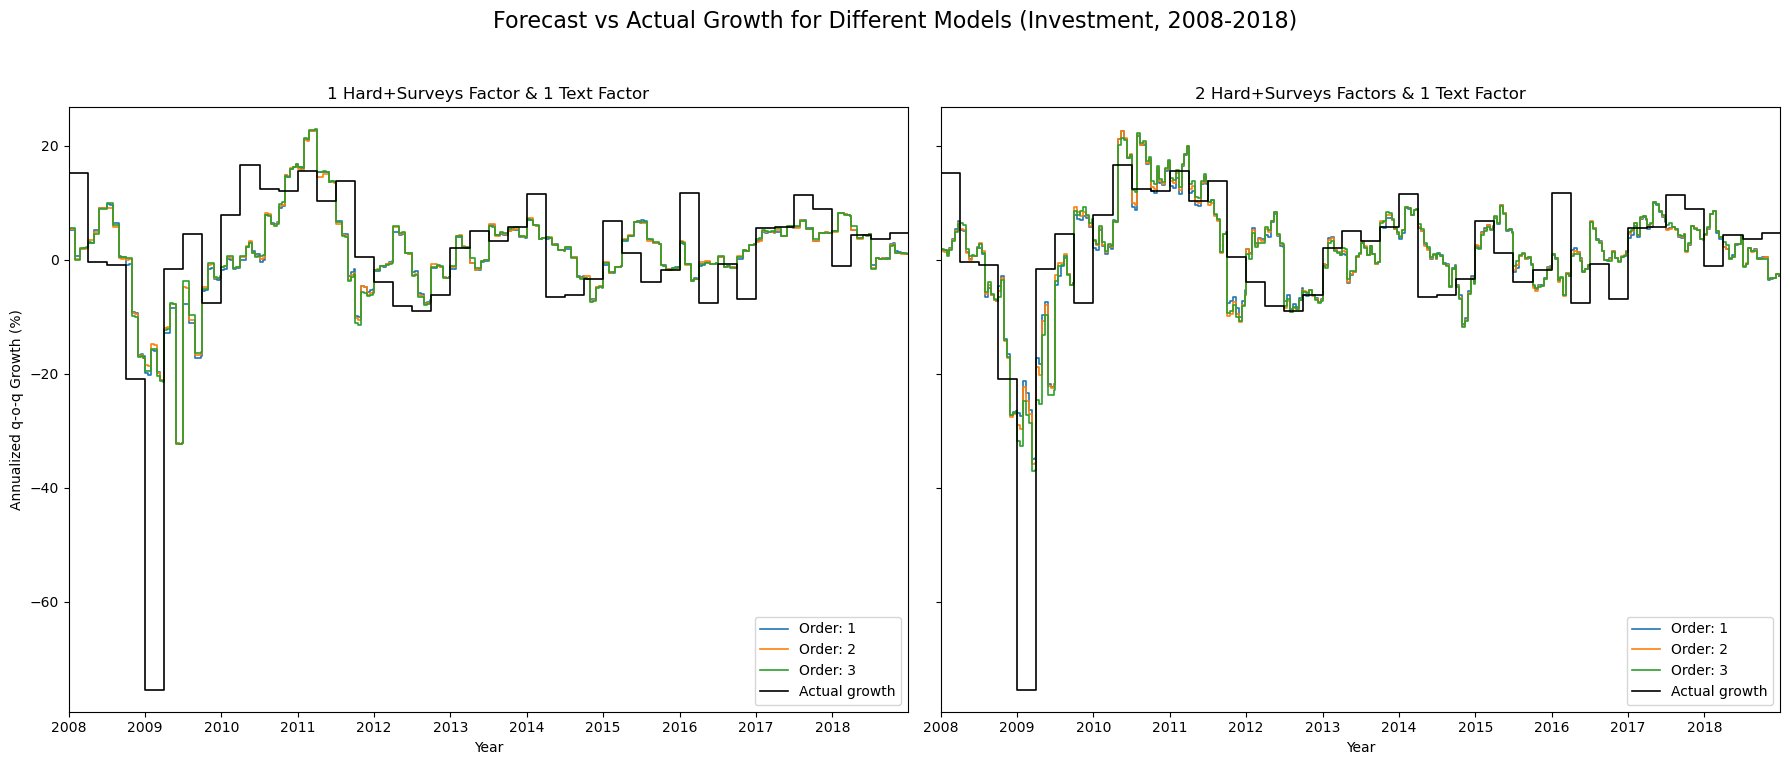

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


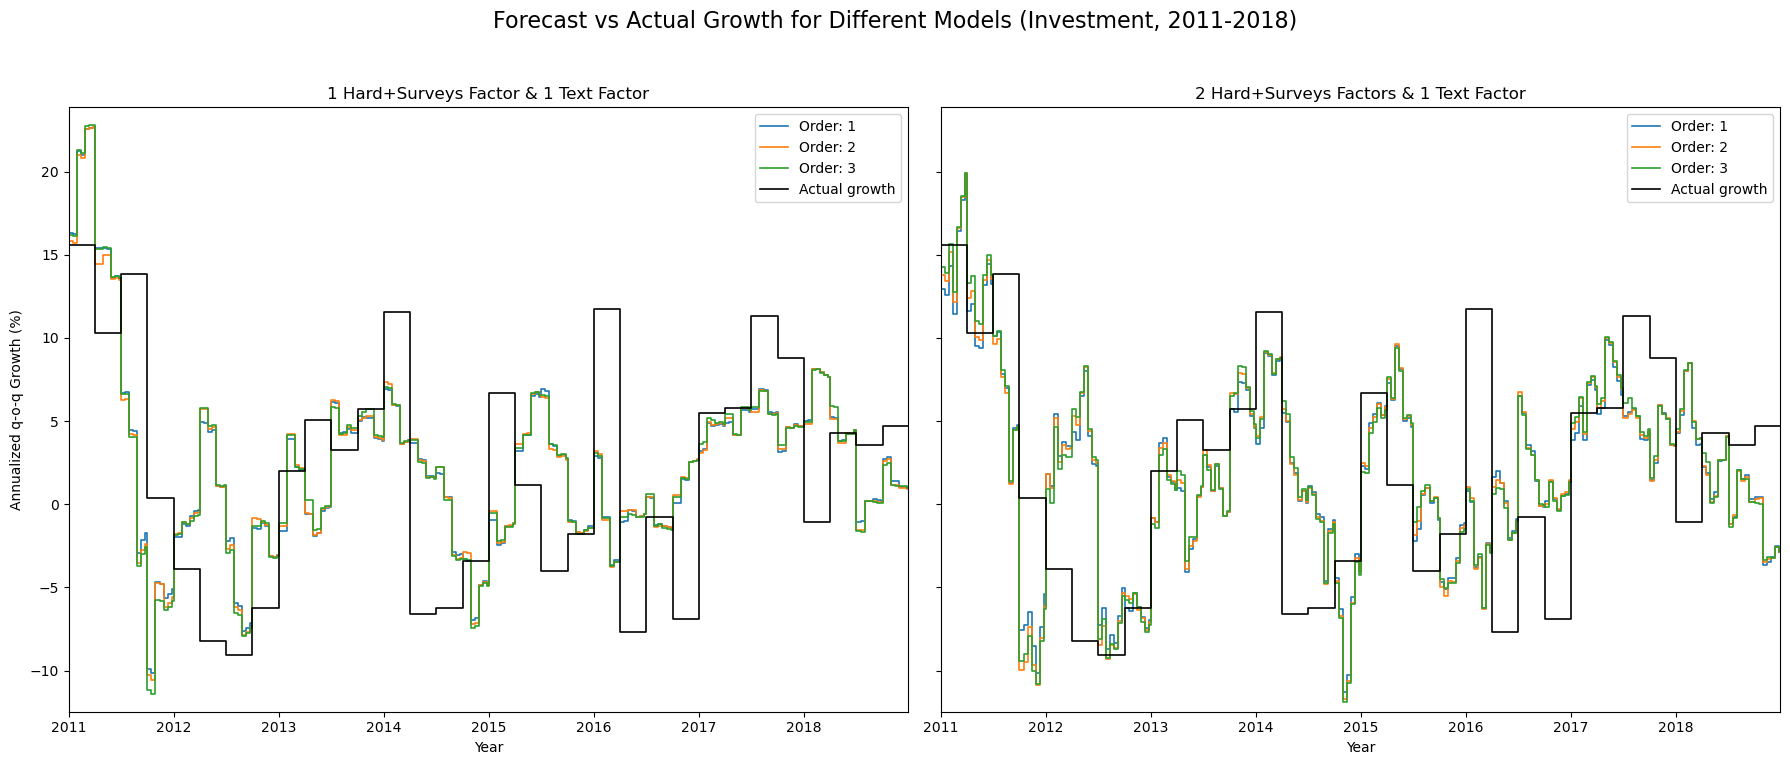

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()